# Problem 4

This problem tests whether you can read an abstract description of a "new" algorithm (or rather, one which most of you might not have seen before) and implement it.

> This problem has six (6) exercises and is worth a total of ten (10) points.

The algorithm is called [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN), which is short for _density-based spatial clustering for applications with noise_. It addresses a limitation of $k$-means clustering, as described below.

Although there are existing implementations for Python (e.g., [see here](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.dbscan.html)), in this notebook we are asking you to build it from scratch, albeit using a lot of scaffolding that we have provided.

## Setup

Here are the modules you will need for this problem.

In [1]:
from IPython.display import display

import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

# Adapted from: https://blog.dominodatalab.com/topology-and-density-based-clustering/
def make_crater (inner_rad=4, outer_rad=4.5, donut_len=2, inner_pts=1000, outer_pts=500, label=False):
    # Make the inner core
    radius_core = inner_rad*np.random.random (inner_pts)
    direction_core = 2*np.pi*np.random.random (size=inner_pts)

    # Simulate inner core points
    core_x = radius_core*np.cos (direction_core)
    core_y = radius_core*np.sin (direction_core)
    crater_core = pd.DataFrame ({'x_1': core_x, 'x_2': core_y})
    if label: crater_core['label'] = 0

    # Make the outer ring
    radius_ring = outer_rad + donut_len*np.random.random(outer_pts)
    direction_ring = 2*np.pi*np.random.random(size = outer_pts)

    # Simulate ring points
    ring_x = radius_ring*np.cos(direction_ring)
    ring_y = radius_ring*np.sin(direction_ring)
    crater_ring = pd.DataFrame ({'x_1': ring_x, 'x_2': ring_y})
    if label: crater_ring['label'] = 1

    return pd.concat ([crater_core, crater_ring])

def make_scatter_plot (df, x="x_1", y="x_2", hue="label",
                       palette={0: "red", 1: "olive", 2: "blue", 3: "green"},
                       size=5,
                       centers=None):
    if (hue is not None) and (hue in df.columns):
        sns.lmplot (x=x, y=y, hue=hue, data=df, palette=palette,
                    fit_reg=False)
    else:
        sns.lmplot (x=x, y=y, data=df, fit_reg=False)

    if centers is not None:
        cc = [palette[0], palette[1]] if len(centers) > 1 else [palette[0]]
        plt.scatter (centers[:,0], centers[:,1],
                     marker=u'*', s=500, c=cc)

def make_scatter_plot2 (df, x="x_1", y="x_2", hue="label", size=5):
    if (hue is not None) and (hue in df.columns):
        sns.lmplot (x=x, y=y, hue=hue, data=df,
                    fit_reg=False)
    else:
        sns.lmplot (x=x, y=y, data=df, fit_reg=False)

## Loading the data

We will work work with a synthetic data set that is an especially bad case for $k$-means. It's sometimes called the "crater" data because of its shape. The data points are stored in a file named `crater.csv`.

> The data files you'll need for this problem are pre-loaded in Vocareum. To load them, you'll need to wrap the filenames using the function `fn(f)`, defined below. If you are working locally, you can obtain a copy at the following URL and may need to modify `fn(f)` accordingly: https://cse6040.gatech.edu/datasets/dbscan.zip

In [2]:
def fn(fn_base, dirname='./resource/asnlib/publicdata/'): # `dirname` set by default to the path you need in Vocareum
    return '{}{}'.format(dirname, fn_base)

# Demo:
fn('crater.csv')

'./resource/asnlib/publicdata/crater.csv'

**Exercise 0** (1 point). Start by reading the data into a Pandas data frame. The data is stored locally within this assignment in a file called `crater.csv`. Store your data frame in a variable named `crater`.

In [5]:
crater = pd.read_csv(fn('crater.csv'))

display (crater.head (3))
print ("...")
display (crater.tail (3))

,x_1,x_2,kmeans_label
0,-1.719159,-2.500154,1
1,-3.002477,-4.801853,1
2,0.469441,1.591334,0


...


,x_1,x_2,kmeans_label
1497,0.278229,0.162659,1
1498,-0.939762,3.127528,0
1499,-1.506346,5.179035,0



(Passed!)


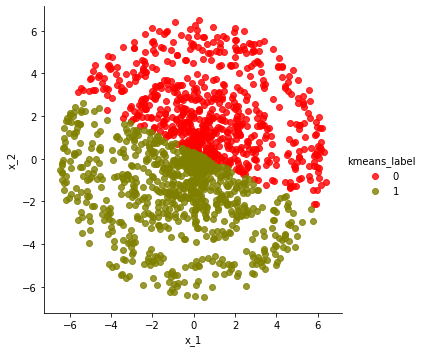

In [6]:
assert len (crater) == 1500
assert set (crater.columns) == set (['x_1', 'x_2', 'kmeans_label'])

with open (fn('crater_counts.txt'), 'rt') as fp:
    true_counts = [int (c) for c in fp.read ().split (',')]
    assert sum (crater['kmeans_label'] == 0) == true_counts[0]
    assert sum (crater['kmeans_label'] == 1) == true_counts[1]
    
make_scatter_plot (crater, hue='kmeans_label')

print ("\n(Passed!)")

The testing code plots these data points, which are 2-D. The colors show the clusters computed by $k$-means for $k=2$. Notice that the "natural" structure is, arguably, a dense ball in the middle and a ring (donut) on the outside. However, $k$-means instead split the points about an arbitrary line that cuts through the middle of the points.

Indeed, this fact is one of the limitations of $k$-means: it works well when you know the value of $k$ and the $k$ clusters come from Gaussian distributions of similar shape and size (and, therefore, density). However, if you don't know $k$ or there is non-uniform shape and density among the clusters---or some other grouping, as above---then $k$-means does not work well (qualitatively).

## Elements of DBSCAN

The DBSCAN algorithm takes a different approach. Rather than having to provide the number of clusters, $k$, you define parameters related to _neighborhoods_ and _target density_. Let's see how DBSCAN works by building it from the ground up.

### Neighborhoods

The first important concept in DBSCAN is that of an _$\epsilon$-neighborhood_.

Consider any point $p$. The $\epsilon$-neighborhood of $p$ is the set of all points within a distance of $\epsilon$ from $p$. That is, if $\{\hat{x}_0, \hat{x}_1, \ldots, \hat{x}_{m-1}\}$ is a collection of $m$ data points, then the $\epsilon$-neighborhood centered at $p$ is

$$
  N_{\epsilon}(p) = \{\hat{x}_i : \|\hat{x}_i - p\|_2 \leq \epsilon\},
$$

where the measure of distance is Euclidean (i.e., the two-norm). Notice that this definition would _include_ the point $p$ if $p$ is one of the data points.

**Exercise 1** (1 point). Implement a function that computes the $\epsilon$-neighborhood of $p$ for a data matrix of points, $X$, defined by our usual convention as

$$
  X = \left( \begin{array}{c} \hat{x}_0^T \\ \hat{x}_1^T \\ \vdots \\ \hat{x}_{m-1}^T \end{array} \right).
$$

In particular, complete the function named `region_query(p, eps, X)` below. Its inputs are:

- `p[:d]`: The query point, of dimension `d`.
- `eps`: The size of the ball around `p` to search.
- `X[:m, :d]`: The set of points, i.e., data matrix.

It should return a boolean Numpy array `adj[:m]` with one entry per point (i.e., per row of `X`). The entry `adj[i]` should be `True` only if `X[i, :]` lies within the `eps`-sized ball centered at `p`.

> _Hint:_ There is a one-line solution of the form, `return (boolean array expression)`.

In [7]:
def region_query (p, eps, X):
    # These lines check that the inputs `p` and `X` have
    # the right shape.
    _, dim = X.shape
    assert (p.shape == (dim,)) or (p.shape == (1, dim)) or (p.shape == (dim, 1))
    return np.linalg.norm(p-X, axis=1) <= eps

#https://kitchingroup.cheme.cmu.edu/pycse/pycse.html#orgdc87f47

Here is the test code for `region_query()`. In addition to sanity-checking your solution, it plots the original points, a query point (marked by a red star), and highlights all points in an $\epsilon$-neighborhood computed by your function so you can visually verify the result. (In this test, $p=(-0.5, 1.2)$ and $\epsilon=1.0$.)


(Passed!)


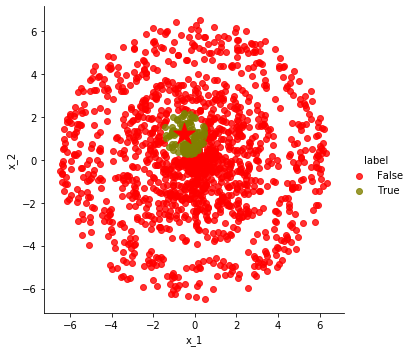

In [8]:
X = crater[['x_1', 'x_2']].values
p = np.array ([-0.5, 1.2])
in_region = region_query (p, 1.0, X)

crater_ball = crater.copy ()
crater_ball['label'] = in_region
make_scatter_plot (crater_ball, centers=p[np.newaxis])

with open (fn('region_query_soln.txt'), 'rt') as fp:
    assert int (fp.read ()) == sum (in_region)

print ("\n(Passed!)")

**Exercise 2** (1 point). Suppose you are given a vector `y[:]` of boolean (`True` and `False`) values, such as the one computed above. Write a function named `index_set(y)` that returns the index locations of all of `y`'s `True` elements. **Your function must return these index values as a Python set.**

In [19]:
def index_set (y):
    """
    Given a boolean vector, this function returns
    the indices of all True elements.
    """
    assert len (y.shape) == 1
    from itertools import compress
    return set (np.where (y)[0])

#other options: (filter(lambda i: y[i], range(len(y)))) 
#from itertools import compress
#return set (compress(range(len(y)), y))
#https://www.geeksforgeeks.org/python-get-indices-of-true-values-in-a-binary-list/

In [20]:
y_test = np.array ([True, False, False, True, False, True, True, True, False])
i_soln = set ([0, 3, 5, 6, 7])

i_test = index_set (y_test)
assert type (i_test) is set
assert len (i_test) == len (i_soln)
assert i_test == i_soln

print ("\n(Passed!)")


(Passed!)


**Exercise 3** (1 point). Given a value for $\epsilon$ and a data matrix $X$ of points, complete the function below so that it determines the neighborhood of each point.

Your function,

```python
    def find_neighbors(eps, X[:m, :]):
        ...
```

should return a Python list `neighbors[:m]` such that `neighbors[i]` is the index set of neighbors of point `X[i, :]`.

In [23]:
def find_neighbors (eps, X):
    m, d = X.shape
    neighbors = [] # Empty list to start
    for i in range (len(X)):
        n_i = index_set(region_query(X[i, :], eps, X))
        neighbors.append(n_i)
    assert len (neighbors) == m
    return neighbors

In [24]:
with open (fn('find_neighbors_soln.csv'), 'rt') as fp:
    neighbors = find_neighbors (0.25, X)
    for i, n_i in enumerate (neighbors):
        j_, c_j_ = fp.readline ().split (',')
        assert (i == int (j_)) and (len (n_i) == int (c_j_))
        
print ("\n(Passed!)")


(Passed!)


### Density

The next important concept in DBSCAN is that of the _density_ of a neighborhood. Intuitively, the DBSCAN algorithm will try to "grow" clusters around points whose neighborhoods are sufficiently dense.

Let's make this idea more precise.

**Definition: _core points_.** A point $p$ is a _core point_ if its $\epsilon$-neighborhood has at least $s$ points.

In other words, the algorithm now has two user-defined parameters: the neighborhood size, $\epsilon$, and the minimum density, specified using a threshold $s$ on the number of points in such a neighborhood.

**Exercise 4** (2 points). Complete the function, `find_core_points(s, neighbors)`, below. It takes as input a minimum-points threshold, `s`, and a list of point neighborhoods, `neighbors[:]`, such that `neighbors[i]` is the (index) set of neighbors of point `i`. It should return a Python set, `core_set`, such that an index `j in core_set` only if the size of the neighborhood at `j` is at least `s`.

In [27]:
def find_core_points (s, neighbors):
    assert type (neighbors) is list
    assert all ([type (n) is set for n in neighbors])
    
    core_set = set ()
    for i, n_i in enumerate(neighbors):
        if len(n_i) >= s:
            core_set.add(i)
    return core_set

Found 623 core points.

(Passed!)


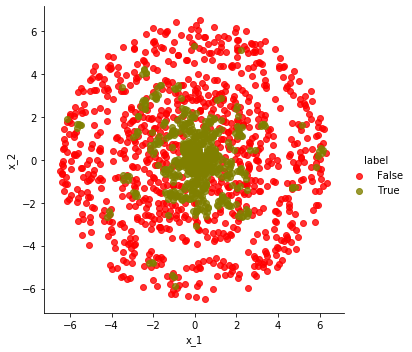

In [28]:
core_set = find_core_points (5, neighbors)
print ("Found {} core points.".format (len (core_set)))

def plot_core_set (df, core_set):
    df_labeled = df.copy ()
    df_labeled['label'] = False
    df_labeled.loc[list (core_set), 'label'] = True
    make_scatter_plot (df_labeled)
    
plot_core_set (crater, core_set)

with open (fn('find_core_points_soln.txt'), 'rt') as fp:
    core_set_soln = set ([int (i) for i in fp.read ().split ()])
    assert core_set == core_set_soln
    
print ("\n(Passed!)")

### Growing clusters via "reachable" points

The last concept needed for DBSCAN is the idea of _growing_ a cluster around a core point. It depends on the notion of _reachability_.

**Definition: Reachability.** A point $q$ is _reachable_ from another point $p$ if there exists a sequence of points $p=p_1, p_2, \ldots, p_k=q$ such that every $p_i$ is a core point, possibly except for $p_k=q$, and $p_{i} \in N_\epsilon(p_{i-1})$ for all $1 < i < k$.

This procedure works as follows.

**"Expand Cluster"** procedure:
1. Consider any point $p$ that is not yet assigned to a cluster.
2. If $p$ is a core point, then start a new cluster for it.
3. Maintain a "reachable" set, which will be used to hold points that are reachable from $p$ as they are encountered. Initially, the reachable points are just $p$'s $\epsilon$-neighbors.
4. Remove any point $q$ from the reachable set.
5. If $q$ has not yet been visited, then mark it as being visited.
6. If $q$ is also a core point, then add all of its neighbors to the reachable set, per the definition of "reachability" above.
7. If $q$ is not yet assigned to any cluster, then add it to $p$'s cluster.

Notice how this procedure explores the points reachable from $p$ (Step 6). Intuitively, it is trying to join all neighborhoods whose core points are mutually contained.

Here is a brief illustration of these concepts:

![Example: Growing clusters](./eps-example--small.png)

In this picture, suppose the minimum density parameter is $s=3$ points. Thus, only the $\epsilon$-neighborhoods centered at 1, 3, and 6 are core points, since these are the only points that include at least $s=3$ points. For instance, $N_\epsilon(1) = \{0, 1, 3, 7\}$, making it a core point since its neighborhood has four (4) points, whereas $N_\epsilon(4) = \{3, 4\}$ is not a core point since its neighborhood has just two (2) points.

**Exercise 5** (4 points). Implement the "cluster growth" procedure described above in the function, `expand_cluster()`, below.

To simplify your task, we will **give you all the lines of code that you need.** However, you need to figure out in what order these lines must execute, as well as how to indent them!

The signature of the function is:

```python
def expand_cluster (p, neighbors, core_set, visited, assignment):
    ...
```

Its parameters are:

- `p` is the _index_ of a starting core point. The caller must guarantee that it is indeed a core point, and furthermore, that it has been assigned to some cluster. (See below.)
- `neighbors[:]` is a list of $\epsilon$-neighborhoods, given as Python sets. For instance, `neighbors[p]` is a set of indices of all points in the neighborhood of `p`. It will have been computed from `find_neighbors()` above.
- `core_set` is a Python set containing the indices of all core points. That is, the expression, **`i in core_set`**, is true only if `i` is indeed a core point.
- `visited` is another Python set containing the indices of all points that have already been visited. That is, the expression **`i in visited`** should be `True` only if `i` has been visited. Thus, your `expand_cluster()` function should update this set when visiting any previously unvisited point.
- `assignment` is a Python dictionary. The key is the index of a point; the value is the cluster label to which that point has been assigned. Consequently, if a point `i` does not yet have any cluster assignment, then the expression, **`i in assignment`**, will be **`False`**. Your `expand_cluster()` function should update cluster assignments by updating this dictionary.

The skeleton of `expand_cluster()` does everything up to and including Step 4 of the procedure above. It first initializes the reachable set as a Python set, `reachable`, containing the neighbors of `p`. It then removes one of those reachable points, storing it in `q`. You just need to perform steps 5-7. In fact, we will even give you all of the lines of code that you need! But you have to to incorporate them into the skeleton, ordered and indented correctly.

```python
assignment[q] = assignment[p]
if q in core_set:
if q not in assignment:
if q not in visited:
reachable |= neighbors[q]
visited.add (q)
```

In [33]:
def expand_cluster (p, neighbors, core_set, visited, assignment):
    # Assume the caller performs Steps 1 and 2 of the procedure.
    # That means 'p' must be a core point that is part of a cluster.
    assert (p in core_set) and (p in visited) and (p in assignment)
    
    reachable = set (neighbors[p])  # Step 3
    while reachable:
        q = reachable.pop () # Step 4
        
        # Put your reordered and correctly indented statements here:
        if q not in visited:
            visited.add (q) # Mark q as visited
            if q in core_set:
                reachable |= neighbors[q]
        if q not in assignment:
            assignment[q] = assignment[p]
        
    # This procedure does not return anything
    # except via updates to `visited` and
    # `assignment`.

In [34]:
# This test is based on the illustration above.
p_test = 3
neighbors_test = [set ([0, 1]),
                  set ([0, 1, 3, 7]),
                  set ([2, 3]),
                  set ([1, 2, 3, 4, 6]),
                  set ([3, 4]),
                  set ([5]),
                  set ([3, 6, 7]),
                  set ([1, 7])
                 ]
core_set_test = set ([1, 3, 6])
visited_test = set ([p_test])
assignment_test = {p_test: 0}
expand_cluster (p_test, neighbors_test, core_set_test,
                visited_test, assignment_test)
assert visited_test == set ([0, 1, 2, 3, 4, 6, 7]) # All but 5
assert set (assignment_test.keys ()) == visited_test
assert set (assignment_test.values ()) == set ([0])

print ("\n(Passed!)")


(Passed!)


### Putting it all together

If you've successfully completed all steps above, then you have everything you need to run the final DBSCAN algorithm, which we've provided below. The second code cell below shows a picture of the clusters discovered for a particular setting of neighborhood size, $\epsilon$, and density threshold, $s$.

And there is **no additional code for you to write below**! However, you should make sure the remaining cells execute without error.

In [35]:
def dbscan (eps, s, X):
    clusters = []
    point_to_cluster = {}
    
    neighbors = find_neighbors (eps, X)
    core_set = find_core_points (s, neighbors)
    
    assignment = {}
    next_cluster_id = 0

    visited = set ()
    for i in core_set: # for each core point i
        if i not in visited:
            visited.add (i) # Mark i as visited
            assignment[i] = next_cluster_id
            expand_cluster (i, neighbors, core_set,
                            visited, assignment)
            next_cluster_id += 1

    return assignment, core_set

Number of core points: 904
Number of clusters: 12
Number of unclassified points: 394

(Passed!)


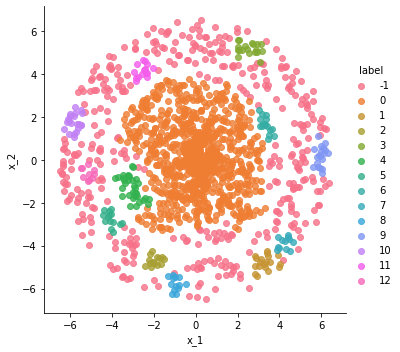

In [36]:
assignment, core_set = dbscan (0.5, 10, X)

print ("Number of core points:", len (core_set))
print ("Number of clusters:", max (assignment.values ()))
print ("Number of unclassified points:", len (X) - len (assignment))

def plot_labels (df, labels):
    df_labeled = df.copy ()
    df_labeled['label'] = labels
    make_scatter_plot2 (df_labeled)

labels = [-1] * len (X)
for i, c in assignment.items ():
    labels[i] = c
plot_labels (crater, labels)

with open (fn('dbscan_soln.csv'), 'rt') as fp:
    num_cores, num_clusters, num_outliers = fp.read ().split (',')
    assert int (num_cores) == len (core_set)
    assert int (num_clusters) == max (assignment.values ())
    assert int (num_outliers) == (len (X) - len (assignment))
print ("\n(Passed!)")

**Fin!** If you've reached this point and all tests above pass, you are ready to submit your solution to this problem. Don't forget to save you work prior to submitting.